<a href="https://colab.research.google.com/github/aaaaaamah99/Computer_Vision/blob/main/Klasifikasi_COVID_19_dan_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19normalpneumonia-ct-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F832492%2F1421897%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T175359Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D01cf73e1da6ebb0b2684ca1ce920349211a481f7a1f7eb40ef947e391886ab25045c9142b9ca2d6c529c3698b4401276560eb55097924fbb4c688b9349af9ca8a1c1f2e1ead71c1a9d576903cee6452fcdbac5d79d23ad0522ae21f1cf1394c1e89e2f84d4b169eb60867d70c714da520d2ea4b1220b8d37bf30e6239079d9eb82beabe7a9c4e42677a92d5066059997a728dc849a1b8fd8853c2b13c0421083c9b2a2924dc1dee79b7fe7f3e7842d38e683de4908302fc582221d4a70332038659f87375a429109edebd182012375c93cd6c34cc3d039112c94c49a92c9a91b0a41f28657fb4ca604a42d02de28ccf758471ce0c043f87313e024cc50c11fdb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Import Libraries**

In [ ]:
!pip install --upgrade tensorflow keras


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import shutil
import random
import cv2
import zipfile
import matplotlib.cm as cm

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import Progbar
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import path
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model  # Correct import path for plot_model
from tensorflow.keras.utils import get_custom_objects
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# **Delete Old Directory**

In [ ]:
try:
    shutil.rmtree("./train")
    shutil.rmtree("./test")
    shutil.rmtree("./val")

except OSError as e:
    print("Directories never existed")

# **CREATE DIRECTORY and SPLIT into TRAIN, TEST, VALIDATION**

In [ ]:
path = "../input/covid19normalpneumonia-ct-images"
classesPath = ['COVID2_CT', 'Normal_CT', 'pneumonia_CT']

np.random.seed(seed = 90)

val_ratio = 0.1
test_ratio = 0.1
seed = 90

for cls in classesPath:
    os.makedirs('./train/' + cls)
    os.makedirs('./val/' + cls)
    os.makedirs('./test/' + cls)

    src = path + "/" + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                               int(len(allFileNames) * (1 - test_ratio))])

    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

    print('Total ', str(cls), len(allFileNames))
    print('Training', len(train_FileNames))
    print('Validation', len(val_FileNames))
    print('Testing', len(test_FileNames))
    print("\n")

    for name in train_FileNames:
        shutil.copy(name, './train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, './val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, './test/' + cls)

Total  COVID2_CT 2035
Training 1628
Validation 203
Testing 204


Total  Normal_CT 2119
Training 1695
Validation 212
Testing 212


Total  pneumonia_CT 3390
Training 2712
Validation 339
Testing 339




# **Creating image data generator for training and testing**

In [ ]:
path_train = "./train"
path_val = "./val"
path_test = "./test"

batch_size = 32
batch_test_size = 16
seed = 90
interpolation = "bicubic"
target_size = (256, 256)
epochs = 50

train_data_gen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.1,  # Geser gambar secara horizontal sebesar 10% lebar gambar
                                    height_shift_range=0.1, # Geser gambar secara vertikal sebesar 10% tinggi gambar
                                    shear_range=0.2,        # Miringkan gambar dengan rentang 20 derajat
                                    zoom_range=0.2,         # Perbesar atau perkecil gambar hingga 20%
                                    horizontal_flip=True,  # Putar gambar secara horizontal secara acak
                                    fill_mode='nearest')    # Isi piksel yang kosong dengan nilai terdekat)


test_data_gen = ImageDataGenerator()

ds_train = train_data_gen.flow_from_directory(directory = path_train,
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              target_size = target_size,
                                              shuffle = True,
                                              interpolation = interpolation,
                                              seed = seed)

ds_val = test_data_gen.flow_from_directory(directory = path_val,
                                           color_mode = "rgb",
                                           batch_size = batch_size,
                                           class_mode='categorical',
                                           target_size = target_size,
                                           shuffle = True,
                                           interpolation = interpolation,
                                           seed = seed)

ds_test = test_data_gen.flow_from_directory(directory = path_test,
                                            color_mode = "rgb",
                                            batch_size = batch_test_size,
                                            target_size = target_size,
                                            class_mode='categorical',
                                            shuffle = False,
                                            interpolation = interpolation,
                                            seed = seed)

Found 6035 images belonging to 3 classes.
Found 754 images belonging to 3 classes.
Found 755 images belonging to 3 classes.


# **MODEL CNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam

# Define the input shape based on your image dimensions
input_shape = (256, 256, 3)  # Replace height, width, and channels with actual values
# Definisikan model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3))  # Menggunakan tiga unit karena ada tiga kelas
model.add(Activation('softmax'))  # Aktivasi softmax untuk klasifikasi multikelas


model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 252, 252, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 252, 252, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 122, 122, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 59, 59, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 57, 57, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 57, 57, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 57, 57, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 256)    │       295,16

 Total params: 20,054,563 (76.50 MB)

 Trainable params: 20,051,619 (76.49 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Nadam

# Tentukan lokasi penyimpanan model terbaik dengan ekstensi .keras
filepath = "best_model_3.keras"

# Definisikan ModelCheckpoint untuk menyimpan model terbaik berdasarkan validasi accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')

# List semua callbacks yang akan digunakan (tanpa EarlyStopping)
callbacks_list = [checkpoint]

# Compile model dengan optimizer dan loss function yang sesuai
model.compile(optimizer=Nadam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Tentukan jumlah epoch yang diinginkan
epochs = 50

# Latih model dengan generator data pelatihan dan validasi, sambil menggunakan callbacks
history = model.fit(ds_train, epochs=epochs, validation_data=ds_val, shuffle=True, callbacks=callbacks_list)


Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 136s 635ms/step - accuracy: 0.4681 - loss: 1.1173 - val_accuracy: 0.6565 - val_loss: 0.7727
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 117s 596ms/step - accuracy: 0.6464 - loss: 0.7594 - val_accuracy: 0.7838 - val_loss: 0.4779
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 117s 594ms/step - accuracy: 0.7070 - loss: 0.6429 - val_accuracy: 0.7493 - val_loss: 0.5233
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 117s 598ms/step - accuracy: 0.7366 - loss: 0.5782 - val_accuracy: 0.7931 - val_loss: 0.4674
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 116s 592ms/step - accuracy: 0.7829 - loss: 0.4780 - val_accuracy: 0.7454 - val_loss: 0.6273
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 116s 593ms/step - accuracy: 0.8144 - loss: 0.4328 - val_accuracy: 0.7003 - val_loss: 0.8802
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 116s 592ms/step - accuracy: 0.8253 - loss: 0.3982 - val_accuracy: 0.8024 - val_loss: 0.4775
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 117s 599ms/step - accuracy: 0.8285 -

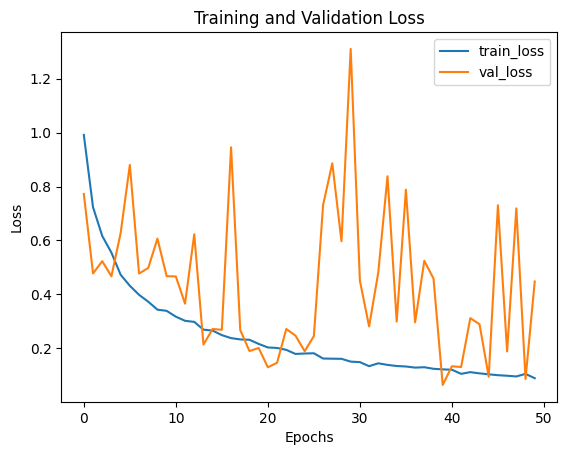

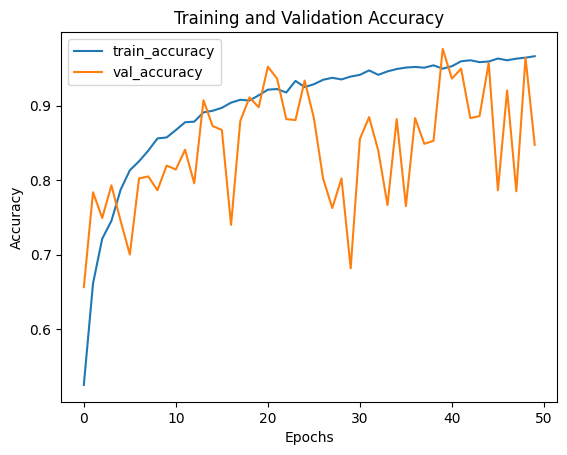

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


**Train**

In [ ]:
# Evaluasi model menggunakan data uji
test_loss, test_accuracy = model.evaluate(ds_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2024-05-31 17:37:03.148875: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129032: 6.23419, expected 5.28448
2024-05-31 17:37:03.148931: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129033: 6.10421, expected 5.15451
2024-05-31 17:37:03.148940: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129034: 7.09771, expected 6.148
2024-05-31 17:37:03.148949: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129035: 8.03191, expected 7.08221
2024-05-31 17:37:03.148957: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129036: 7.06707, expected 6.11736
2024-05-31 17:37:03.148965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129037: 7.7164, expected 6.76669
2024-05-31 17:37:03.148973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 129038: 8.14916, expected 7.19946
2024-05-31 17:37:03.148981: E 

47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8740 - loss: 0.3626

2024-05-31 17:37:10.183079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64516: 6.18098, expected 5.39172
2024-05-31 17:37:10.183130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64517: 6.55985, expected 5.77059
2024-05-31 17:37:10.183140: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64535: 6.50052, expected 5.71126
2024-05-31 17:37:10.183148: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64536: 5.76942, expected 4.98016
2024-05-31 17:37:10.183156: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64546: 5.63759, expected 4.84833
2024-05-31 17:37:10.183164: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64547: 5.26415, expected 4.47489
2024-05-31 17:37:10.183172: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 64548: 6.22564, expected 5.43638
2024-05-31 17:37:10.183179: E exte

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.8729 - loss: 0.3645
Test Loss: 0.4087289869785309
Test Accuracy: 0.8476821184158325


**Confusion Matrix**

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step


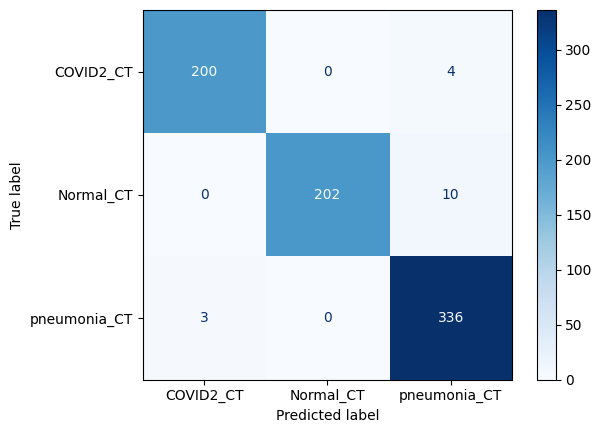

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Muat model terbaik yang disimpan selama pelatihan
best_model = load_model(filepath)

# Prediksi pada data uji menggunakan model terbaik
y_pred_prob = best_model.predict(ds_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Mendapatkan label sebenarnya
y_true = ds_test.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(ds_test.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# **ResNet50**

In [ ]:
model_ResNet = ResNet50V2(weights='imagenet',include_top=False)
full_name = "ResNet_Model"

x = model_ResNet.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)

y_hat = Dense(3,'softmax', name = "Output")(x)

model_ResNet = Model(inputs=model_ResNet.input, outputs = y_hat)

if not os.path.exists("./Weights"):
    os.makedirs('./Weights')
if not os.path.exists("./Weights/ResNet"):
    os.makedirs('./Weights/ResNet')

filepath = "./Weights/ResNet/%s-Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name

plot_model(model_ResNet, show_shapes = True, show_layer_names = True, to_file = "ResNet.png")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint('./Weights/ResNet/ResNet_Model-Final-{epoch:02d}-{val_accuracy:.4f}.keras', monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [earlystop, checkpoint]
model_ResNet.compile(optimizer=Nadam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

historyResNet = model_ResNet.fit(ds_train, epochs=epochs, validation_data=ds_val, shuffle=True, callbacks=callbacks_list)


Epoch 1/50


I0000 00:00:1717177116.251068     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_21', 4 bytes spill stores, 4 bytes spill loads



 27/189 ━━━━━━━━━━━━━━━━━━━━ 3:34 1s/step - accuracy: 0.5964 - loss: 0.8478   

I0000 00:00:1717177150.810809     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_21', 4 bytes spill stores, 4 bytes spill loads



189/189 ━━━━━━━━━━━━━━━━━━━━ 199s 734ms/step - accuracy: 0.8223 - loss: 0.4224 - val_accuracy: 0.8316 - val_loss: 0.5593
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 118s 602ms/step - accuracy: 0.9671 - loss: 0.1016 - val_accuracy: 0.9682 - val_loss: 0.0901
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 124s 632ms/step - accuracy: 0.9811 - loss: 0.0498 - val_accuracy: 0.9682 - val_loss: 0.0904
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 125s 640ms/step - accuracy: 0.9819 - loss: 0.0569 - val_accuracy: 0.9111 - val_loss: 0.3755
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 128s 652ms/step - accuracy: 0.9894 - loss: 0.0373 - val_accuracy: 0.9788 - val_loss: 0.0536
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 125s 634ms/step - accuracy: 0.9899 - loss: 0.0301 - val_accuracy: 0.8475 - val_loss: 0.4512
Epoch 7/50
133/189 ━━━━━━━━━━━━━━━━━━━━ 32s 586ms/step - accuracy: 0.9904 - loss: 0.0265

In [ ]:
plt.plot(historyResNet.history['accuracy'])
plt.plot(historyResNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(historyResNet.history['loss'])
plt.plot(historyResNet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluasi model menggunakan data uji
test_loss, test_accuracy = model_ResNet.evaluate(ds_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')